In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="*********")
project = rf.workspace("joseph-nelson").project("thermal-dogs-and-people")
version = project.version(6)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os

# Define the base directory for the new ImageFolder dataset
imagefolder_dir = '/content/ThermalDogsAndPeople_ImageFolder'

# Create the folder structure for ImageFolder, including the "mixed" class
os.makedirs(os.path.join(imagefolder_dir, 'train/dog'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'train/person'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'train/mixed'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'valid/dog'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'valid/person'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'valid/mixed'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'test/dog'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'test/person'), exist_ok=True)
os.makedirs(os.path.join(imagefolder_dir, 'test/mixed'), exist_ok=True)

print("Folder structure created with the 'mixed' class.")

Folder structure created with the 'mixed' class.


In [ ]:
import shutil

# Function to move images to the respective class folders, with "mixed" images placed only in the "mixed" folder
def move_images_to_class_folders(base_dir, output_base_dir, phase):
    images_dir = os.path.join(base_dir, phase, 'images')
    labels_dir = os.path.join(base_dir, phase, 'labels')

    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Identify the class labels in the annotation file
        classes_in_file = set([int(line.split()[0]) for line in lines])  # YOLO format uses class index

        # Skip images that have no class annotations
        if not classes_in_file:
            print(f"Skipping {label_file}: no class annotations found.")
            continue

        image_name = label_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_dir, image_name)

        # Determine the target folder
        if len(classes_in_file) > 1:  # If there are multiple classes, use "mixed" only
            target_folder = os.path.join(output_base_dir, phase, 'mixed')
        else:  # Otherwise, copy to the specific class folder
            class_index = next(iter(classes_in_file))
            if class_index == 0:  # Assuming 0 is for 'dog'
                target_folder = os.path.join(output_base_dir, phase, 'dog')
            elif class_index == 1:  # Assuming 1 is for 'person'
                target_folder = os.path.join(output_base_dir, phase, 'person')

        # Ensure the target directory exists
        os.makedirs(target_folder, exist_ok=True)

        # Copy the image to the target directory
        target_path = os.path.join(target_folder, image_name)
        shutil.copy(image_path, target_path)

# Clear existing content in the output directories before re-running
def clear_directory(base_dir):
    for phase in ['train', 'valid', 'test']:
        for class_name in ['dog', 'person', 'mixed']:
            folder_path = os.path.join(base_dir, phase, class_name)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                os.remove(file_path)

# Clear the previously copied files
clear_directory(imagefolder_dir)

# Apply the function to move images for each phase
for phase in ['train', 'valid', 'test']:
    move_images_to_class_folders('/content/Thermal-Dogs-and-People-6', imagefolder_dir, phase)

print("Dataset has been reorganized with images placed exclusively in one class (dog, person, or mixed).")

Skipping IMG_0019-3_jpg.rf.3323c0a8b60166c7fc33321c75f3de2e.txt: no class annotations found.
Skipping IMG_0007-4_jpg.rf.400116181e9dd624c8dbbe2d304386ce.txt: no class annotations found.
Skipping IMG_0021-3_jpg.rf.7765ba5a7d973ad878a06c23d36fd2fa.txt: no class annotations found.
Skipping IMG_0001-4_jpg.rf.8ec382489d0af254d192ec42666e982a.txt: no class annotations found.
Skipping IMG_0004_jpg.rf.426913803a6a5fc801db1176eb63ef04.txt: no class annotations found.
Skipping IMG_0054-2_jpg.rf.e4a5e78091e90a88853a972af3d28818.txt: no class annotations found.
Skipping IMG_0001_jpg.rf.7a4664496bb452375ac63af3248c1833.txt: no class annotations found.
Skipping IMG_0008-3_jpg.rf.9096317d49b44266ea25ef0a32a72f71.txt: no class annotations found.
Skipping IMG_0020-3_jpg.rf.94840f3667fab783b1b0df3d5bc5d242.txt: no class annotations found.
Skipping IMG_0055-2_jpg.rf.50f186e108f098b6c76e8b7beaa355ce.txt: no class annotations found.
Skipping IMG_0005_jpg.rf.a8a9cbbb4d7c44e7ecba83ebce9f173d.txt: no class an

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


data_dir = '/content/ThermalDogsAndPeople_ImageFolder'


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Define transformations for validation and test sets (no data augmentation)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

This section loads the pre-trained AlexNet model, which has been trained on the ImageNet dataset. The final fully connected layer (the 6th layer in the classifier module) is replaced with a new Linear layer that outputs 3 classes (dog, person, and mixed). This allows the model to adapt to the new dataset without altering its core structure.

Freezing is also performed on pretrained layers. Freezing the parameters of the feature extraction layers means only the classifier layers at the end of the model will be updated during training. This transfer learning approach leverages AlexNet's learned features on ImageNet while reducing the training time and computational cost for the new dataset.

In [ ]:
# Load datasets

train_dataset = ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = ImageFolder(root=os.path.join(data_dir, 'valid'), transform=basic_transform)
test_dataset = ImageFolder(root=os.path.join(data_dir, 'test'), transform=basic_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained AlexNet
alexnet_model = models.alexnet(weights='IMAGENET1K_V1')
alexnet_model.classifier[6] = nn.Linear(alexnet_model.classifier[6].in_features, 3)  # Adjust for 3 classes

# Freeze all layers except the final classifier layer
for param in alexnet_model.features.parameters():
    param.requires_grad = False

alexnet_model = alexnet_model.to(device)

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

In [ ]:
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, num_epochs=25):
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 7  # Set desired patience

    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_preds.double() / total_samples
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct_preds += torch.sum(preds == labels.data)
                val_total_samples += inputs.size(0)

        val_epoch_loss = val_running_loss / val_total_samples
        val_epoch_acc = val_correct_preds.double() / val_total_samples
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        # Scheduler step
        scheduler.step(val_epoch_loss)

        # Early Stopping Check
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [ ]:
# call Training function
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model_with_early_stopping(
    alexnet_model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25: Train Loss: 2.4460, Train Acc: 0.4504, Val Loss: 3.2273, Val Acc: 0.3889
Epoch 2/25: Train Loss: 1.4366, Train Acc: 0.4504, Val Loss: 0.6820, Val Acc: 0.6389
Epoch 3/25: Train Loss: 0.7459, Train Acc: 0.6565, Val Loss: 0.3427, Val Acc: 0.8056
Epoch 4/25: Train Loss: 0.6648, Train Acc: 0.7557, Val Loss: 1.0122, Val Acc: 0.6111
Epoch 5/25: Train Loss: 0.6808, Train Acc: 0.7405, Val Loss: 1.6995, Val Acc: 0.3889
Epoch 6/25: Train Loss: 1.0257, Train Acc: 0.6947, Val Loss: 0.1475, Val Acc: 0.9722
Epoch 7/25: Train Loss: 0.6908, Train Acc: 0.7634, Val Loss: 0.2680, Val Acc: 0.8889
Epoch 8/25: Train Loss: 0.6858, Train Acc: 0.7863, Val Loss: 0.1814, Val Acc: 0.9444
Epoch 9/25: Train Loss: 0.6998, Train Acc: 0.7557, Val Loss: 0.7519, Val Acc: 0.6111
Epoch 10/25: Train Loss: 0.7536, Train Acc: 0.7405, Val Loss: 0.2591, Val Acc: 0.8889
Epoch 11/25: Train Loss: 0.5739, Train Acc: 0.7634, Val Loss: 0.2645, Val Acc: 0.8611
Epoch 12/25: Train Loss: 0.3589, Train Acc: 0.8550, Val Loss: 0

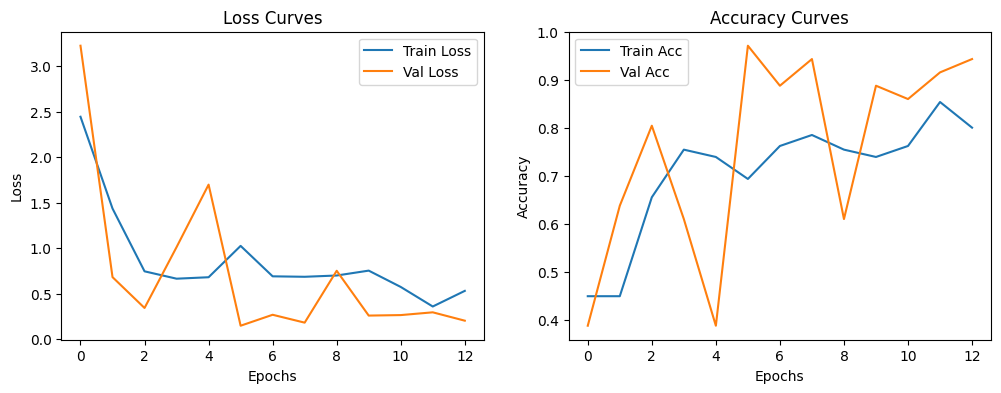

In [ ]:
# Step 5: Plot Training/Validation Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
def evaluate_model_on_test_set(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_preds = 0
    test_total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track the test loss and accuracy
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct_preds += torch.sum(preds == labels.data)
            test_total_samples += inputs.size(0)

    # Calculate average test loss and accuracy
    test_loss = test_running_loss / test_total_samples
    test_accuracy = test_correct_preds.double() / test_total_samples

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_model_on_test_set(alexnet_model, test_loader, criterion)

Test Loss: 0.1846, Test Accuracy: 0.9444


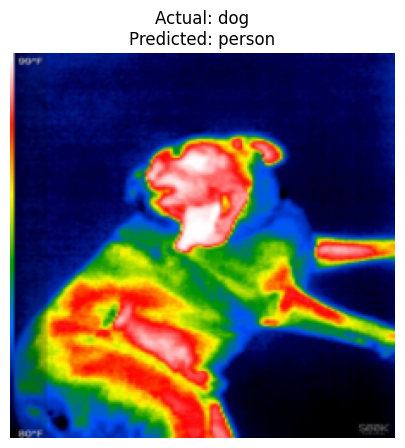

Number of misclassified samples: 1


In [ ]:


def find_misclassified_samples(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find misclassified samples
            misclassified_mask = (preds != labels)
            misclassified_images.extend(inputs[misclassified_mask].cpu())
            misclassified_labels.extend(labels[misclassified_mask].cpu())
            misclassified_preds.extend(preds[misclassified_mask].cpu())

    return misclassified_images, misclassified_labels, misclassified_preds

def display_misclassified_samples(misclassified_images, misclassified_labels, misclassified_preds, class_names, num_samples=5):
    # Display a few misclassified samples
    num_samples = min(num_samples, len(misclassified_images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image = misclassified_images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        image = image * 0.5 + 0.5  # Unnormalize the image
        actual_label = class_names[misclassified_labels[i]]
        predicted_label = class_names[misclassified_preds[i]]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()

# Class names for the dataset
class_names = train_dataset.classes  # ['dog', 'person', 'mixed']

# Find misclassified samples
misclassified_images, misclassified_labels, misclassified_preds = find_misclassified_samples(alexnet_model, test_loader)

# Display a few misclassified samples
display_misclassified_samples(misclassified_images, misclassified_labels, misclassified_preds, class_names, num_samples=5)

print(f"Number of misclassified samples: {len(misclassified_images)}")

In [ ]:
import matplotlib.pyplot as plt

def display_correctly_classified_samples_per_class(correctly_classified_images, correctly_classified_labels, correctly_classified_preds, class_names, num_samples_per_class=2):

    # Create a dictionary to store samples for each class
    samples_per_class = {class_name: [] for class_name in class_names}

    # Collect samples per class
    for img, label, pred in zip(correctly_classified_images, correctly_classified_labels, correctly_classified_preds):
        actual_label_name = class_names[label]
        if len(samples_per_class[actual_label_name]) < num_samples_per_class:
            samples_per_class[actual_label_name].append((img, label, pred))

    # Plot the samples
    plt.figure(figsize=(15, 5))
    for class_index, (class_name, samples) in enumerate(samples_per_class.items()):
        for i, (img, label, pred) in enumerate(samples):
            img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
            img = img * 0.5 + 0.5  # Unnormalize the image (assuming normalization mean=0.5, std=0.5)
            actual_label = class_names[label]
            predicted_label = class_names[pred]
            plt.subplot(len(class_names), num_samples_per_class, class_index * num_samples_per_class + i + 1)
            plt.imshow(img)
            plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()


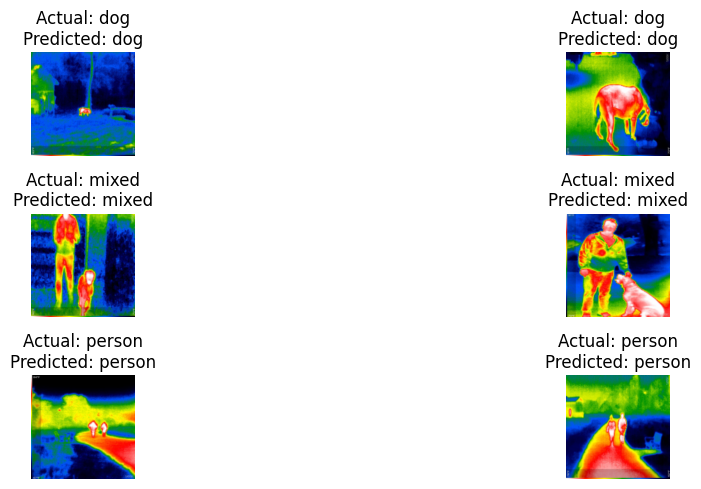

Number of correctly classified samples: 17


In [ ]:
import torch
import matplotlib.pyplot as plt

def get_correctly_classified_samples(model, dataloader, class_names):
    model.eval()
    correctly_classified_images = []
    correctly_classified_labels = []
    correctly_classified_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Identify correctly classified samples
            for i in range(inputs.size(0)):
                if preds[i] == labels[i]:
                    correctly_classified_images.append(inputs[i].cpu())
                    correctly_classified_labels.append(labels[i].cpu().item())
                    correctly_classified_preds.append(preds[i].cpu().item())

    return correctly_classified_images, correctly_classified_labels, correctly_classified_preds


correctly_classified_images, correctly_classified_labels, correctly_classified_preds = get_correctly_classified_samples(
    alexnet_model, test_loader, class_names
)

#calling the function to display correctly classified samples
display_correctly_classified_samples_per_class(
    correctly_classified_images, correctly_classified_labels, correctly_classified_preds, class_names, num_samples_per_class=2
)

print(f"Number of correctly classified samples: {len(correctly_classified_images)}")
